In [1]:
import os
from datetime import datetime
import traceback

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torchvision
import numpy as np
import pandas as pd

from tqdm import tqdm
from tensorboardX import SummaryWriter

from dataset import voc
from retinanet import model, val
from retinanet import transforms as aug
%matplotlib inline

In [2]:
# consts
tag = 'debug'
split_name = 'voc-1'
root_path = '/home/voyager/data/root/voc/'

device_name = 'cpu'
batch_size = 24
epochs = 200
depth = 50
lr = 1e-5
patience = 3
image_size = 512
score_thresholds = [0.01, 0.02, 0.03, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
max_detections = 4
num_classes = 2

# info and deps
now = datetime.now()

if not os.path.exists('./result'):
    os.mkdir('./result')

result_path = './result/{}_{}_{}_{}'.format(
    tag,
    depth,
    split_name,
#     now.strftime('%Y%m%d_%H%M%S')
    "20190516_175626"
)

model_name = "151_0.3333"

summary_writer = SummaryWriter(result_path)

In [3]:
val_trans = aug.Compose([
    aug.Pad(),
    aug.Resize(image_size, image_size),
    aug.AutoLevel(min_level_rate=1, max_level_rate=1),
    aug.AutoContrast(),
    aug.Contrast(1.25),
    aug.ToTensor()
])

val_set = voc.VOCDetection(
    root_path,
    image_set="{}_val".format(split_name),
#     image_set="{}_train".format(split_name),
    transforms=val_trans
)

val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=voc.collate
)
val_set

In [4]:
net = torch.load(os.path.join(result_path, model_name +".pth"))

In [6]:
def _get_detections(dataset, retinanet, num_classes=2, score_threshold=0.05, max_detections=100, save_path=None, model_name=None):
    
    all_detections = [[None for i in range(num_classes)] for j in range(len(dataset))]
    retinanet.eval()
    
    with torch.no_grad():

        for index in range(len(dataset)):
            data = dataset[index]
            # data is a tuple: (img, ([labels], [gts], {scale, pad_loc...}))
            scale = data[1][2]["scale"]
            # get pad loc, up, down, left, right
            pad_loc = data[1][2]["pad_loc"]

            # run network
            scores, labels, boxes = retinanet(data[0].permute(0, 1, 2).cuda().float().unsqueeze(dim=0))
            scores = scores.cpu().numpy()
            labels = labels.cpu().numpy()
            boxes  = boxes.cpu().numpy()
            
            # correct boxes for image scale
            boxes /= scale
#             print(boxes.shape)
            for bbx in boxes:
                # height fix
                bbx[1] -= pad_loc[0]
                bbx[3] -= pad_loc[0]
                # width fix
                bbx[0] -= pad_loc[2]
                bbx[2] -= pad_loc[2]
            

            # select indices which have a score above the threshold
            indices = np.where(scores > score_threshold)[0]
            if indices.shape[0] > 0:
                # select those scores
                scores = scores[indices]

                # find the order with which to sort the scores
                scores_sort = np.argsort(-scores)[:max_detections]

                # select detections
                image_boxes      = boxes[indices[scores_sort], :]
                image_scores     = scores[scores_sort]
                image_labels     = labels[indices[scores_sort]]
                image_detections = np.concatenate([image_boxes, np.expand_dims(image_scores, axis=1), np.expand_dims(image_labels, axis=1)], axis=1)
                                
                # copy detections to all_detections
                for label in range(num_classes):
                    all_detections[index][label] = image_detections[image_detections[:, -1] == label, :-1]
            else:
                # copy detections to all_detections
                for label in range(num_classes):
                    all_detections[index][label] = np.zeros((0, 5))
            
#             print("{}/{}".format(index + 1, len(dataset)), end='\r')
            print("\r {}/{}".format(index + 1, len(dataset)), end='')
    
    # save all_detections to a csv under save_path
    if save_path:
        csv_data = pd.DataFrame(columns=['id', 'serial', 'class', 'score', 'x1', 'y1', 'x2', 'y2', 'prob'])
    
        for index in range(len(all_detections)):
            image_name = dataset.images[index].split('/')[-1].split('.')[0]
            for label in range(len(all_detections[index])):
                for box in range(len(all_detections[index][label])):
                    bbx = all_detections[index][label][box]
                    csv_data.loc[index] = [image_name, box, label, 0, bbx[0], bbx[1], bbx[2], bbx[3], bbx[4]]
        file_name = "{}_{}_{}_{}".format(
            model_name,
            num_classes,
            score_threshold,
            max_detections
        )
        csv_data.to_csv(os.path.join(save_path, file_name)+".csv")
    
    return all_detections

In [7]:
score_threshold = score_thresholds[0]
score_threshold = 0.9
all_detections = _get_detections(val_set, net, num_classes=num_classes, score_threshold=score_threshold, max_detections=max_detections, save_path=result_path, model_name=model_name)

/home/voyager/anaconda3/envs/pytorch_0.4.1/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


 317/317

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(tensor([1, 0]), tensor([[239.3766,  82.2857, 360.7273, 437.1948],
        [255.1688,  81.4545, 331.6364, 358.2338]]), {'pad_loc': [0, 0, 68.0, 68.0], 'scale': 0.8311688311688312}) 
 [[217.24816895 145.56228638 363.01742554 531.32775879   0.93271393]]


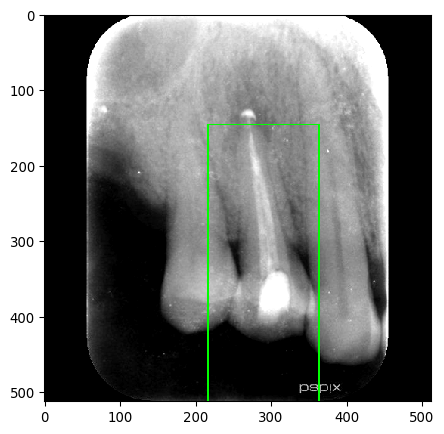

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


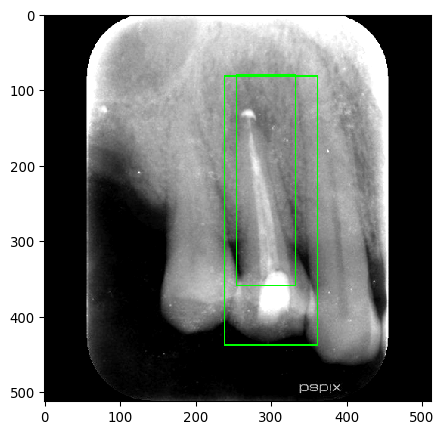

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(tensor([0, 1]), tensor([[198.5641, 101.7436, 358.5641, 235.4872],
        [107.4872,  82.8718, 360.2051, 235.4872]]), {'pad_loc': [0, 0, 80.0, 80.0], 'scale': 0.8205128205128205}) 
 [[ 55.40867615  89.84758759 355.47259521 299.86749268   0.9589262 ]]


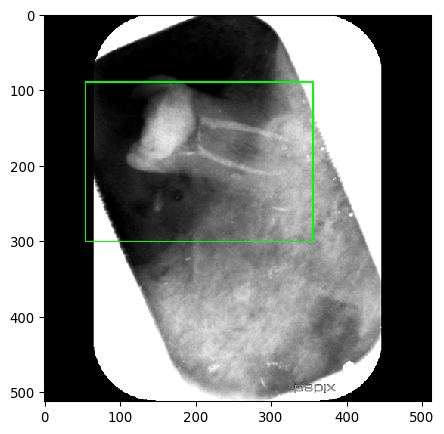

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


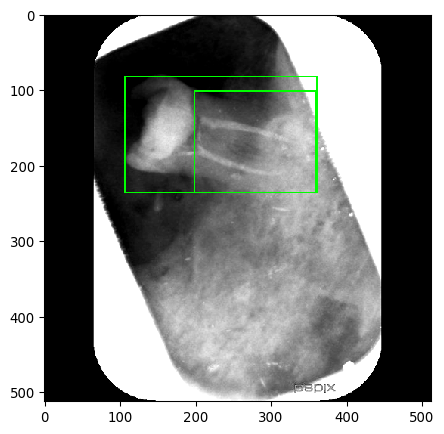

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(tensor([0, 1]), tensor([[221.7931,  62.8966, 438.0690, 327.7242],
        [199.7241,  65.1034, 440.2758, 457.9310]]), {'pad_loc': [0, 0, 40.0, 40.0], 'scale': 1.103448275862069}) 
 [[130.63682556  48.68155289 354.71682739 423.53625488   0.97539943]]


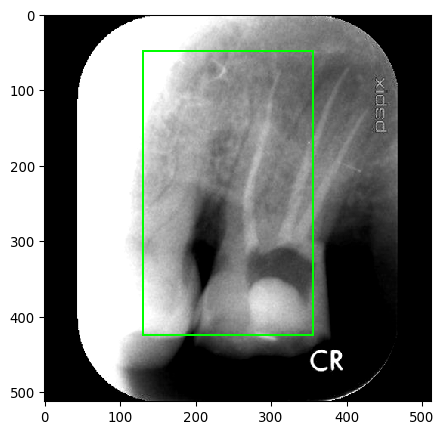

KeyboardInterrupt: 

In [9]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

def show_bbs(img, anno):
    gts = anno[1].numpy()
    np_img = img.to(dtype=torch.float32).cpu().numpy()
    np_img = np.transpose(np_img, (1, 2, 0))

    bbs = []
    for gt in gts:
        bbs.append(BoundingBox(x1=gt[0], y1=gt[1], x2=gt[2], y2=gt[3]))

    bbs_on_img = BoundingBoxesOnImage(bbs, shape=np_img.shape)
    draw_img = bbs_on_img.draw_on_image(np_img, size=2)
    ia.imshow(draw_img)

def show_det_bbs(img, anno):
    gts = anno
    np_img = img.to(dtype=torch.float32).cpu().numpy()
    np_img = np.transpose(np_img, (1, 2, 0))

    bbs = []
    for gt in gts:
        bbs.append(BoundingBox(x1=gt[0], y1=gt[1], x2=gt[2], y2=gt[3]))

    bbs_on_img = BoundingBoxesOnImage(bbs, shape=np_img.shape)
    draw_img = bbs_on_img.draw_on_image(np_img, size=2)
    ia.imshow(draw_img)
    
for i, dets in enumerate(all_detections):
    if len(dets[0]) > 0 or len(dets[1]) > 0:
        img, anno = val_set[i]
        
        all_dets = np.vstack((all_detections[i][0], all_detections[i][1]))
        print(anno, '\n', all_dets)
        show_det_bbs(img, all_dets)
        show_bbs(img, anno)
        
    if i > 16:
        break